In [ ]:
!sudo pip3 install -U spacy

     |████████████████████████████████| 6.0 MB 5.3 MB/s 
     |████████████████████████████████| 10.1 MB 50.8 MB/s 
     |████████████████████████████████| 653 kB 49.2 MB/s 
     |████████████████████████████████| 181 kB 46.7 MB/s 
     |████████████████████████████████| 42 kB 994 kB/s 
     |████████████████████████████████| 451 kB 49.5 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [ ]:
!python -m spacy download es_core_news_lg

     |████████████████████████████████| 569.1 MB 20 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')


In [ ]:
# IMPORTS
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, Conv1D, GlobalMaxPooling1D
from keras.models import Model, Sequential
import keras
import tensorflow as tf
from keras.layers import LSTM
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
sst_home='drive/My Drive/NLP GRUPO/'

Mounted at /content/drive


# Recopilación de datos

In [ ]:
data = pd.read_csv(sst_home+"/PARMEX_2022-main/parmex_train.csv") # 7601

text_1_df = data["Text1"]
text_2_df = data["Text2"]
label_df = data["Label"]

In [ ]:
data.head()

,Text1,Text2,Label
0,"su nombre proviene de los persas, los cuales e...","el alimento, cuyo nombre proviene de los persa...",1
1,"la congelación con deshidratación, uno de los ...","un método de cocción es el sous vide, que mant...",0
2,"la empresa de catering caterers bubble, de lon...",el festival de alcachofa ahumada instantánea ...,0
3,el sous vide es un método de cocción que manti...,estos se usan para referir a las transformacio...,0
4,el cuidado de la piel también es un factor a t...,la dieta general de la gente consiste en carne...,0


# Analisis de datos

La diferencia entre las clases, mostrada en la celda anterior, puede afectar al rendimiento del modelo. Por ello, se hará un primer entrenamiento sin balanceo de clases y otro con el dataset balanceado para ver si la diferencia del rendimiento es muy notable.

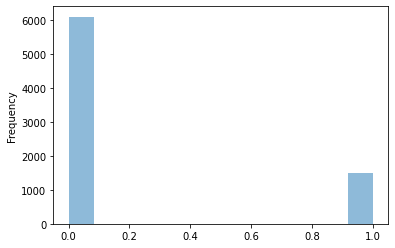

In [ ]:
# Distribución de clases
ax = label_df.plot.hist(bins=12, alpha=0.5)

In [ ]:
 
print("Positivos=", len(data[data["Label"] == 1]))
print("Negativos=", len(data[data["Label"] == 0]))
 

Positivos= 1501
Negativos= 6100


# 1. Modelo de clasificación básico

In [ ]:
import spacy

nlp = spacy.load("es_core_news_lg")

In [ ]:
tokens=[]
for i, text in text_1_df.items(): 
    tok_1 = nlp(text)
    tok_2 = nlp(text_2_df[i])
    tok_3 = np.concatenate([tok_1.vector, tok_2.vector])
    tokens.append(tok_3)

print(len(tokens), len(label_df))

7601 7601


# División de datos

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tokens, label_df, test_size=0.2, random_state=42)

# Entrenamiento del modelo

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [ ]:
pipeline = Pipeline([
    ('classifier', SVC()),
])

pipeline.fit(X_train,y_train)
predictions = pipeline.predict(X_test)

print( classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90      1831
           1       0.80      0.13      0.22       450

    accuracy                           0.82      2281
   macro avg       0.81      0.56      0.56      2281
weighted avg       0.82      0.82      0.77      2281



Text(0.5, 0, 'predicted label')

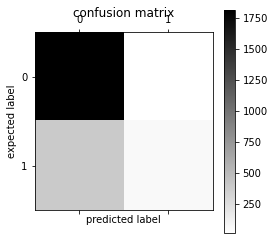

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.matshow(confusion_matrix(y_test, predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [ ]:
import pandas as pd

labels = ['negative', 'positive']

pd.DataFrame(confusion_matrix(y_test, predictions), index=labels, columns=labels)

,negative,positive
negative,1817,14
positive,393,57


In [ ]:
import numpy as np
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

CPU times: user 12.8 s, sys: 411 ms, total: 13.2 s
Wall time: 1min 26s


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

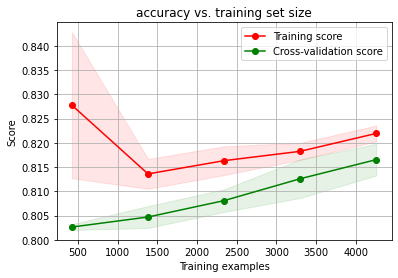

In [ ]:
%time plot_learning_curve(pipeline, "accuracy vs. training set size", X_train, y_train, cv=5)

# Análisis de resultados

El rendimiento del modelo es bastante pobre a la hora de identificar valores positivos. Esto puede darse por la gran diferencia que se encuentra entre las clases. Para confirmar, se hará un segundo entrenamiento con las clases balanceadas.

# 1.2 Entrenamiento con clases balanceadas.

# BALANCEO

- PROBAR HACER OVERSAMPLING 

- SMOTE (libreria)

In [ ]:
trues = 0
falses = 0

new_text_1_df = []
new_text_2_df = []
new_label_df = []

for i, lab in label_df.items():
  if lab == 1:
    trues+=1
    new_text_1_df.append(text_1_df[i])
    new_text_2_df.append(text_2_df[i])
    new_label_df.append(label_df[i])
  else:
    if falses < trues:
      falses+=1
      new_text_1_df.append(text_1_df[i])
      new_text_2_df.append(text_2_df[i])
      new_label_df.append(label_df[i])

new_text_1_df = pd.Series(new_text_1_df)
new_text_2_df = pd.Series(new_text_2_df)
new_label_df = pd.Series(new_label_df)
print(trues, falses)
print("------------")
print(len(new_text_1_df), len(new_text_2_df), len(new_label_df))

1501 1501
------------
3002 3002 3002


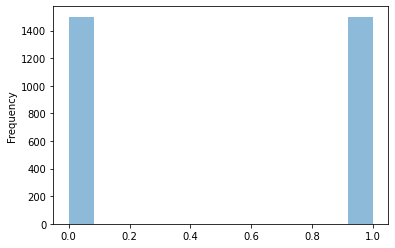

In [ ]:
# Distribución de clases
ax = new_label_df.plot.hist(bins=12, alpha=0.5)

In [ ]:
tokens=[]
for i, text in new_text_1_df.items(): 
    tok_1 = nlp(text)
    tok_2 = nlp(new_text_2_df[i])
    tok_3 = np.concatenate([tok_1.vector, tok_2.vector])
    tokens.append(tok_3)

print(len(tokens), len(new_label_df))

3002 3002


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tokens, new_label_df, test_size=0.3, random_state=42)


# Hacer oversampling sobre el conjunto de entrenamiento (y no cambiar el conjunto de test)

In [ ]:
pipeline = Pipeline([
    ('classifier', SVC()),
])

pipeline.fit(X_train,y_train)
predictions = pipeline.predict(X_test)

print( classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.66      0.79      0.72       459
           1       0.73      0.58      0.64       442

    accuracy                           0.69       901
   macro avg       0.69      0.68      0.68       901
weighted avg       0.69      0.69      0.68       901



Text(0.5, 0, 'predicted label')

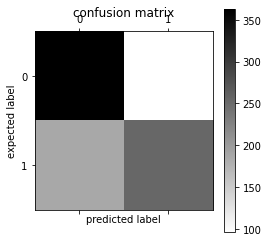

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.matshow(confusion_matrix(y_test, predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [ ]:
labels = ['negative', 'positive']

pd.DataFrame(confusion_matrix(y_test, predictions), index=labels, columns=labels)

,negative,positive
negative,363,96
positive,187,255


CPU times: user 5.24 s, sys: 152 ms, total: 5.4 s
Wall time: 24.3 s


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

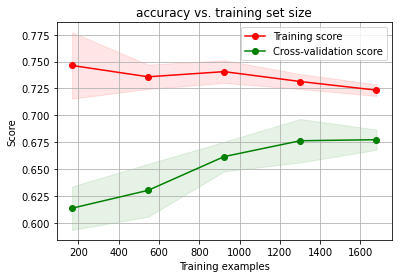

In [ ]:
%time plot_learning_curve(pipeline, "accuracy vs. training set size", X_train,y_train, cv=5)

# Análisis del resultado

Tras balancear los datos, se ha conseguido una overall accuracy más baja pero el f1 de las predicciones positivas ha aumentado considerablemente pasando de un 0.22 a un 0.64. También podemos observar esta mejora en la matriz de confusión, que en el entrenamiento anterior tenia la celda positiva (1,1) totalmente blanca, es decir no se estaban prediciendo casi nunca bien los valores positivos. Por otro lado, la curva de aprendizaje muestra que aun hay margen de mejora. Este podría conseguirse con más datos.

# 2. Modelo basado en la distancia del coseno

In [ ]:
import scipy


def cosine_distance_wordembedding(s1, s2):
    """gets two texts, obtains their word embeddings and then returns its cosine distance"""
    v1 = nlp(s1)
    v2 = nlp(s2)

    s1 = v1.vector
    s2 = v2.vector
    cosine = 1 - scipy.spatial.distance.cosine(s1, s2)
    #print('Word Embedding method with a cosine distance asses that our two sentences are similar to',round((cosine)*100,2),'%')
    return round((cosine),2)

In [ ]:
# utilizar todo el conjunto de datos 


predicted = []

for i, text1 in new_text_1_df.items():
  text2 = new_text_2_df[i]
  pred = cosine_distance_wordembedding(text1, text2)
  if pred < 0.88:
    predicted.append(0)
  else:
    predicted.append(1)

In [ ]:
pos = 0
for i in predicted:
  if i == 1:
    pos+=1

print(pos)

1183


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

predicted_series = pd.Series(predicted)

precision_recall_fscore_support(new_label_df, predicted_series, average=None)

(array([0.66520066, 0.75401522]),
 array([0.80612925, 0.59427049]),
 array([0.72891566, 0.66467958]),
 array([1501, 1501]))

In [ ]:
print( classification_report(new_label_df, predicted_series))

              precision    recall  f1-score   support

           0       0.67      0.81      0.73      1501
           1       0.75      0.59      0.66      1501

    accuracy                           0.70      3002
   macro avg       0.71      0.70      0.70      3002
weighted avg       0.71      0.70      0.70      3002



# Análisis de resultados

La metodología del cálculo de la distancia del coseno resulta ser bastante buena si se calibra correctamente el porcentaje que se considera como "acierto". Según las pruebas que se han hecho, el umbral 0.80 - 0.90 parece el más adecuado, en concreto, el 0.88 consiguiendo una accuracy del 70% y unas f1-score de 73% y 66%.

- 0.85--> acc:0.62, precision: 0.64/0.61, recall: 0.55/0.69, f1-score: 0.59/0.64
- 0.88--> acc:0.70, precision: 0.67/0.75, recall: 0.81/0.59, f1-score: 0.73/0.66
- 0.9--> acc:0.71, precision: 0.65/0.86, recall: 0.92/0.50, f1-score: 0.76/0.64

# 3. Modelo CNN  

In [ ]:
import re
#nltk.download('stopwords')
from nltk.corpus import stopwords
 
X=[] #list to save the texts
 

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    return text

tokens=[]
for i, text in text_1_df.items(): 
    tok_1 = clean_text(text)
    tok_2 = clean_text(text_2_df[i])
    tok_3 = tok_1 + tok_2
    tokens.append(tok_3)

X=list(tokens)
print(len(X),len(label_df))


7601 7601


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, label_df, test_size=0.3, random_state=42)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
tokenizer.fit_on_texts(X_train)

#we add a word index for the pad tokens
tokenizer.word_index['<PAD>'] = 0
print("Vocabulary size of the training={}".format(len(tokenizer.word_index)))
print("Number of Documents in the training={}".format(tokenizer.document_count))

Vocabulary size of the training=5939
Number of Documents in the training=5320


In [ ]:
# We now transform the words to indexes

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
print(X_train[0].split())
print(train_sequences[0])

['quiz', 'la', 'forma', 'de', 'comercio', 'sea', 'ms', 'particular', 'de', 'las', 'ciudades', 'incluyendo', 'la', 'ciudad', 'de', 'mxico', 'pero', 'los', 'productos', 'son', 'procedentes', 'de', 'reas', 'agrcolas', 'del', 'interior', 'de', 'la', 'repblicael', 'carrito', 'se', 'desplaza', 'por', 'las', 'calles', 'de', 'la', 'ciudad', 'empujado', 'por', 'el', 'comerciante', 'quien', 'oferta', 'su', 'producto']
[624, 3, 34, 2, 457, 187, 22, 164, 2, 15, 197, 625, 3, 66, 2, 47, 57, 7, 65, 25, 626, 2, 534, 346, 14, 215, 2, 3, 1611, 32, 9, 2150, 18, 15, 283, 2, 3, 66, 355, 18, 5, 2151, 1140, 1413, 20, 121]


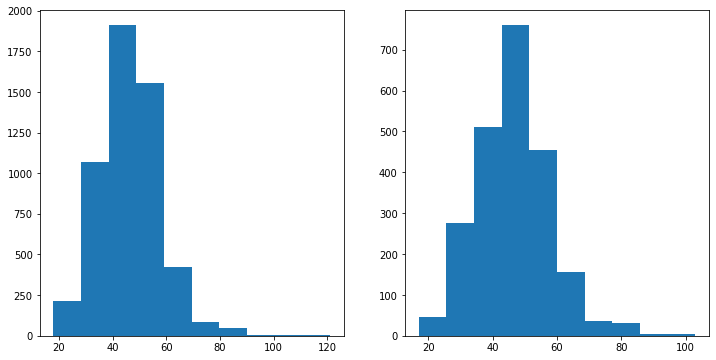

In [ ]:
# The following graph shows the size distribution (number of tokens) of the review

import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [ ]:
MAX_SEQUENCE_LENGTH = 70

# pad dataset to a maximum review length in words
from tensorflow.keras.preprocessing import sequence

train_seq_pad = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_seq_pad = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
train_seq_pad.shape, test_seq_pad.shape

((5320, 1000), (2281, 1000))

In [ ]:
print("length of the first sentence", len(train_sequences[0]), "after padding/trunking:", len(train_seq_pad[0]))
#print(X_train[0])
print(train_seq_pad[0])

length of the first sentence 46 after padding/trunking: 1000
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding


import tensorflow as tf
tf.random.set_seed(1)

VOCAB_SIZE = len(tokenizer.word_index)

EMBED_SIZE = 300
EPOCHS=20
BATCH_SIZE=128

# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 300)         1781700   
                                                                 
 conv1d (Conv1D)             (None, 1000, 64)          76864     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 32000)             0         
                                                                 
 dense (Dense)               (None, 256)               8192256   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')


# Fit the model
model.fit(train_seq_pad, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1, callbacks=[earlyStopping]
          )

Epoch 1/20
38/38 [==============================] - 69s 2s/step - loss: 0.4970 - acc: 0.8030 - val_loss: 0.4688 - val_acc: 0.8008
Epoch 2/20
38/38 [==============================] - 65s 2s/step - loss: 0.4040 - acc: 0.8091 - val_loss: 0.4698 - val_acc: 0.8045
Epoch 3/20
38/38 [==============================] - 66s 2s/step - loss: 0.3295 - acc: 0.8482 - val_loss: 0.5336 - val_acc: 0.8045
Epoch 4/20
38/38 [==============================] - 66s 2s/step - loss: 0.2480 - acc: 0.9027 - val_loss: 0.6563 - val_acc: 0.7519
Epoch 5/20
38/38 [==============================] - 66s 2s/step - loss: 0.1494 - acc: 0.9480 - val_loss: 0.9286 - val_acc: 0.7895
Epoch 6/20
38/38 [==============================] - 66s 2s/step - loss: 0.0884 - acc: 0.9699 - val_loss: 1.1127 - val_acc: 0.7632


In [ ]:
# Final evaluation of the model
scores = model.evaluate(test_seq_pad, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

72/72 [==============================] - 10s 137ms/step - loss: 0.9618 - acc: 0.7843
Accuracy: 78.43%


In [ ]:
predictions=model.predict(test_seq_pad) 
predictions.reshape(-1)
predictions = [1 if item >= 0.5 else 0 for item in predictions]
predictions[:10]

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']

print(classification_report(Y_test, predictions))


              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1831
           1       0.44      0.34      0.38       450

    accuracy                           0.78      2281
   macro avg       0.64      0.62      0.62      2281
weighted avg       0.77      0.78      0.77      2281



In [ ]:
pd.DataFrame(confusion_matrix(Y_test, predictions), index=labels, columns=labels)

,negative,positive
negative,1638,193
positive,299,151


# Modelo de base: TF-IDF 

In [ ]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
stopwords_en = stopwords.words("spanish")

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import re


def cleanText(text):
    text=str(text).lower()
    #tokeniza the text
    tokens=word_tokenize(text)
    #remove the stopwords
    tokens = [word for word in tokens if word not in stopwords_en]
    #(4) obtain the stems
    tokens = [PorterStemmer().stem(word) for word in tokens]
    #(5) finally, remove words with len <3 and words that contain numbers, puntuaction, ect
    min_length = 3
    p = re.compile('[a-zA-Z]+');
    filtered_tokens=[]
    for token in tokens:
        if len(token)>=min_length and p.match(token):
            filtered_tokens.append(token)
            
    return filtered_tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
print(text_1_df[0])
print("-----------")
print(text_2_df[0])



su nombre proviene de los persas, los cuales empleaban este alimento para dar de comer a sus reyes y significa "carne a la parrilla".
-----------
el alimento, cuyo nombre proviene de los persas, que significa “carne a la parrilla”, se empleaba para dar de comer a sus reyes.


In [ ]:
tokens=[]
for i in text_1_df.length: 
    tokens.append(text_1_df[i] + " " + text_2_df[i])

print(len(tokens), len(label_df))


AttributeError: ignored

In [ ]:
print(tokens[0])

la congelación con deshidratación, uno de los nuevos métodos empleados en los restaurantes experimentales, maximiza el sabor y la textura en cada bocado. un método de cocción es el sous vide, que mantiene la integridad de los alimentos al aumentar el calor en ellos durante periodos prolongados a temperaturas relativamente bajas.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tokens, label_df, test_size=0.2, random_state=42)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn import svm

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=cleanText)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', svm.SVC()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

pipeline.fit(msg_train,label_train)
predictions = pipeline.predict(msg_test)